In [133]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_constraint.jl")
include("./trajopt/scaling.jl")
include("./funlopt/funl_synthesis.jl")
# using Plots

run (generic function with 1 method)

In [134]:
# load nominal trajectory
using JLD2, FileIO
@load "./data/quadstar_N15_traj" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [135]:
dynamics = QuadrotorDynamics()
ix = dynamics.ix
iu = dynamics.iu
decay_rate = 0.1
DLMI = NonlinearDLMI(decay_rate,ix,iu,dynamics.Cv,dynamics.Dvu)
is = DLMI.is

1

In [136]:
iϕ = dynamics.iϕ
iv = dynamics.iv
@assert size(xnom,2) - 1 == N

In [137]:
vxy_max = 10.0
vz_max = 3.0
att_vel_max = deg2rad(120)
F_max = 18.0
Mxy_max = 0.3
Mz_max = 0.5
list_const = [
    WayPoint(diagm([0.2^2,0.2^2,0.2^2])),
    StateConstraint([0;0;0; 1;0;0; 0;0;0; 0;0;0],vxy_max),
    StateConstraint([0;0;0; -1;0;0; 0;0;0; 0;0;0],vxy_max),
    StateConstraint([0;0;0; 0;1;0; 0;0;0; 0;0;0],vxy_max),
    StateConstraint([0;0;0; 0;-1;0; 0;0;0; 0;0;0],vxy_max),
    StateConstraint([0;0;0; 0;0;1; 0;0;0; 0;0;0],vz_max),
    StateConstraint([0;0;0; 0;0;-1; 0;0;0; 0;0;0],vz_max),
    StateConstraint([0;0;0; 0;0;0; 0;0;0; 1;0;0],att_vel_max),
    StateConstraint([0;0;0; 0;0;0; 0;0;0; -1;0;0],att_vel_max),
    StateConstraint([0;0;0; 0;0;0; 0;0;0; 0;1;0],att_vel_max),
    StateConstraint([0;0;0; 0;0;0; 0;0;0; 0;-1;0],att_vel_max),
    StateConstraint([0;0;0; 0;0;0; 0;0;0; 0;0;1],att_vel_max),
    StateConstraint([0;0;0; 0;0;0; 0;0;0; 0;0;-1],att_vel_max),

    InputConstraint([1;0;0;0],F_max),
    InputConstraint([-1;0;0;0],0.0),
    InputConstraint([0;1;0;0],Mxy_max),
    InputConstraint([0;-1;0;0],Mxy_max),
    InputConstraint([0;0;1;0],Mxy_max),
    InputConstraint([0;0;-1;0],Mxy_max),
    InputConstraint([0;0;0;1],Mz_max),
    InputConstraint([0;0;0;-1],Mz_max),
    ]

21-element Vector{FunnelConstraint}:
 WayPoint([0.04000000000000001 0.0 0.0; 0.0 0.04000000000000001 0.0; 0.0 0.0 0.04000000000000001])
 StateConstraint([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 10.0)
 StateConstraint([0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0], 10.0)
 StateConstraint([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 10.0)
 StateConstraint([0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0], 10.0)
 StateConstraint([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 3.0)
 StateConstraint([0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0], 3.0)
 StateConstraint([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 2.0943951023931953)
 StateConstraint([0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0], 2.0943951023931953)
 StateConstraint([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 2.0943951023931953)
 ⋮
 StateConstraint([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1], 2.0943951023931953)
 InputConstraint([1, 0, 0, 0], 18.0)
 InputConstraint([-1, 0, 0, 0], 0.0)
 InputConstraint([0, 1, 0, 0], 0.3)
 InputConstraint([0, -1, 0, 0], 0.3)
 InputConstraint([0, 0, 1, 0], 0.3)
 InputCon

In [138]:
# @load "./data/quadstar_N15_gamma" my_dict
# Lipschitz = my_dict["gamma"]
Lipschitz = zeros(N+1);

In [139]:
Qnom = zeros(ix,ix,N+1)
Knom = zeros(iu,ix,N+1)
Znom = zeros(ix,ix,N+1)
lamnom = zeros(1,N+1)
nunom = zeros(1,N+1)
Qini = diagm([0.2^2,0.2^2,0.2^2 ,0.1^2,0.1^2,0.1^2, deg2rad(5)^2,deg2rad(5)^2,deg2rad(5)^2, deg2rad(2)^2,deg2rad(2)^2,deg2rad(2)^2])
Qf = copy(Qini)
# Qini_constant = 1000.0
for i in 1:N+1
    Qnom[:,:,i] .= Qini
    # Qnom[:,:,i] .= (N-i+1)/N*(Qini_constant*Qini)+(i-1)/N*Qf;
end
Xnom,Unom = QKZS_to_XU(Qnom,Knom,Znom,lamnom)

([0.04000000000000001 0.04000000000000001 … 0.04000000000000001 0.04000000000000001; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0012184696791468343 0.0012184696791468343 … 0.0012184696791468343 0.0012184696791468343], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [140]:
xmin = zeros(ix);
xmax = [5,5,5, 3,3,3, pi/3,pi/3,pi/3, pi/3,pi/3,pi/3];
umin = zeros(iu);
umax = [20,0.5,0.5,0.5];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)

Scaling([5.0 0.0 … 0.0 0.0; 0.0 5.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0471975511965976 0.0; 0.0 0.0 … 0.0 1.0471975511965976], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.9549296585513721 0.0; 0.0 0.0 … 0.0 0.9549296585513721], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [20.0 0.0 0.0 0.0; 0.0 0.5 0.0 0.0; 0.0 0.0 0.5 0.0; 0.0 0.0 0.0 0.5], [0.05 0.0 0.0 0.0; 0.0 2.0 0.0 0.0; 0.0 0.0 2.0 0.0; 0.0 0.0 0.0 2.0], [0.0, 0.0, 0.0, 0.0], 14.464262293615677, 0.0, 0.0, 2.128073162e-314)

In [141]:
include("./funlopt/funl_synthesis.jl")

run (generic function with 1 method)

In [197]:
max_iter = 50;
w_funl = 5*1e-3;
w_vc = 2*1e0;
w_tr::Float64 = 1e0
tol_vc = 1e-6;
tol_tr = 1e-5;
tol_dyn = 1e-5;
verbosity = true;

In [198]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,
    w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,verbosity)

FunnelSynthesis(QuadrotorDynamics(12, 4, 9, 7, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.325, 9.81, 0.03843, 0.02719, 0.060528), NonlinearDLMI(0.1, 12, 4, 144, 48, 1, 144, 193, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1]), FunnelConstraint[WayPoint([0.04000000000000001 0.0 0.0; 0.0 0.04000000000000001 0.0; 0.0 0.0 0.04000000000000001]), StateConstraint([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 10.0), StateConstraint([0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0], 10.0), StateConstraint([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 10.0), StateConstraint([0, 0

In [183]:
run(fs,Xnom,Unom,Lipschitz,Qini,Qf,xnom,unom,dtnom,"Mosek")
# run(fs,fs.solution.X,fs.solution.U,Lipschitz,Qini,Qf,xnom,unom,dtnom,"Mosek")
# run(fs,Xnom,Unom,Lipschitz,Qini,Qf,xnom,unom,dtnom,"Clarabel")

The elapsed time of discretization is: 8.264997584 seconds
The elapsed time of solver is: 1.567255973815918 seconds
The elapsed time of subproblem is: 1.904788125 seconds
The elapsed time of multiple shooting is: 0.032468125 seconds
+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   funl    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |0.40        |-1.000    |32.509     |-1.000     |-1.000    |-2.6     | -1.1     |8.8e-01   |
The elapsed time of discretization is: 8.078425 seconds
The elapsed time of solver is: 1.9399340152740479 seconds
The elapsed time of subproblem is: 2.482071583 

In [184]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Xprop,Uprop = fs.solution.Xprop,fs.solution.Uprop
Qprop,Kprop,Zprop,Sprop = XU_to_QKZS(Xprop,Uprop,ix,iu)
Qnode,Knode,Znode,Snode = XU_to_QKZS(fs.solution.X,fs.solution.U,ix,iu)

([9.657971033557175 -0.28519144744535546 … -0.03271315139581587 -0.017728472275330132; -0.28519144744535546 9.682994922451343 … 0.015812789240274624 -0.004914987364506343; … ; -0.03271315139581587 0.01581278924027462 … 0.6546704743878033 0.013792698608290528; -0.01772847227533013 -0.0049149873645063435 … 0.013792698608290528 0.6640452888970241;;; 7.325146263478226 -0.2520952197040521 … 0.2201148495164212 -0.1753440682253934; -0.2520952197040521 6.887317613833499 … -0.1523803557257646 -0.29332835871594576; … ; 0.2201148495164212 -0.1523803557257646 … 0.27496975421028486 -0.08380153201909107; -0.17534406822539342 -0.29332835871594576 … -0.08380153201909107 0.21368453318301367;;; 2.717839543712123 -0.17555724844969078 … 0.2716129410667503 -0.07903609877296844; -0.17555724844969078 2.577297298007748 … -0.1436410823482964 -0.05710344966403059; … ; 0.2716129410667503 -0.14364108234829637 … 0.08330594626546056 0.03217568552587489; -0.07903609877296844 -0.05710344966403058 … 0.0321756855258748

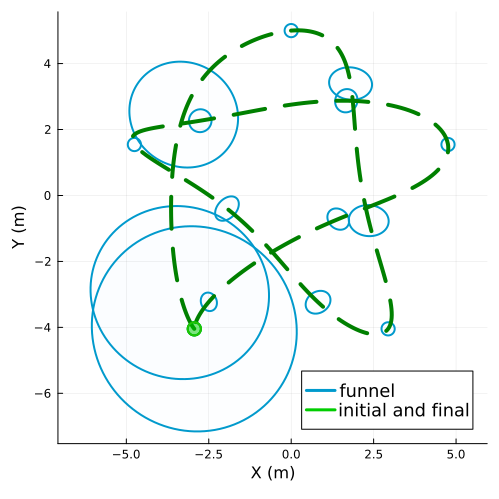

In [185]:
p2 = Plots.plot(; size=(500,500))
# for idx in 1:size(Qprop,3)
#     label = nothing
#     if idx == 1
#         label = "funnel"
#     end
#     plot_ellipse(p2,Qprop[1:2,1:2,idx]/50,xprop[1:2,idx],"deepskyblue3",label=label,alpha=0.01)
# end
for idx in 1:size(Qnode,3)
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[1:2,1:2,idx],xnom[1:2,idx],"deepskyblue3",label=label,alpha=0.01)
end
plot!(xprop[1,:],xprop[2,:],aspect_ratio=:equal,c=:green,linestyle=:dash,linewidth=4.0,label=nothing)
# scatter!(xnom[1,:],xnom[2,:],aspect_ratio=:equal,c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
xlabel!("X (m)")
ylabel!("Y (m)")
display(p2)

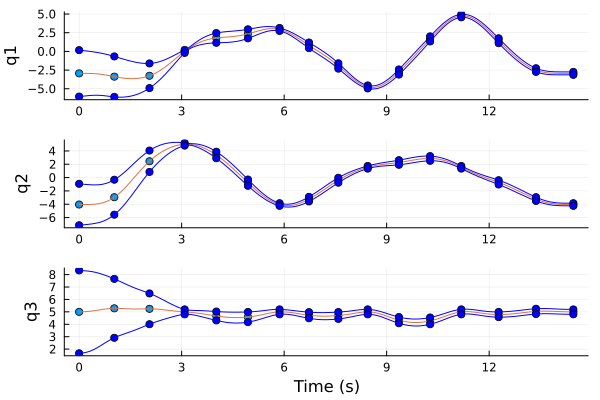

In [186]:
p = []
for idx in 1:3
    push!(p,plot(tnom,xnom[idx,:],seriestype = :scatter,label=""))
    plot!(tprop,xprop[idx,:],label="")
    plot!(tnom,xnom[idx,:] + sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] + sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    plot!(tnom,xnom[idx,:] - sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] - sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    if idx == 3
        xlabel!("Time (s)")
    end
    ylabel!("q" * string(idx))
end
plot(p[1],p[2],p[3],layout=(3,1))

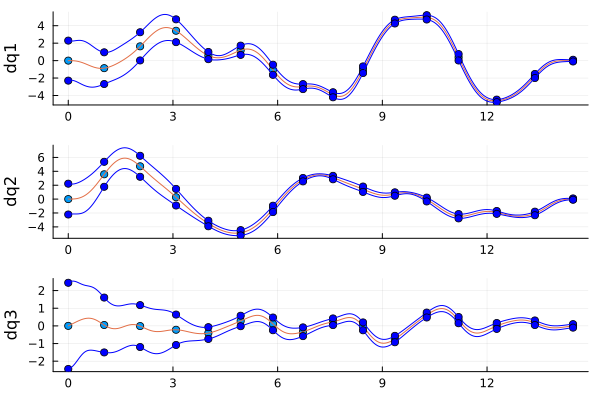

In [187]:
p = []
for idx_ in 1:3
    idx = idx_ + 3
    push!(p,plot(tnom,xnom[idx,:],seriestype = :scatter,label=""))
    plot!(tprop,xprop[idx,:],label="")
    plot!(tnom,xnom[idx,:] + sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] + sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    plot!(tnom,xnom[idx,:] - sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] - sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    if idx == 3
        xlabel!("Time (s)")
    end
    ylabel!("dq" * string(idx_))
end
plot(p[1],p[2],p[3],layout=(3,1))

In [188]:
function project_onto_input(Q,K) 
    R = []
    for i in 1:size(Q,3)
        K_ = K[:,:,i]
        push!(R,K_*Q[:,:,i]*K_')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end
input_proj_funl_nom = project_onto_input(Qnode,Knode)
input_proj_funl_prop = project_onto_input(Qprop,Kprop)

4-element Vector{Any}:
 Any[3.6989106760363213, 3.725078438864105, 3.7506994739903976, 3.7866699380665967, 3.8271264058378196, 3.876320755329461, 3.932199087765528, 3.996278910566874, 4.067837815886427, 4.147297913638967  …  0.07565064858849259, 0.07911020386917923, 0.08287276830326544, 0.08694428394066467, 0.09134022555871484, 0.09608758818962765, 0.10121301497657996, 0.10668717633013877, 0.11236303229297415, 0.11238074193908298]
 Any[0.1808474680147383, 0.17778974389522842, 0.17500779158736285, 0.17139196388524988, 0.1676549846934481, 0.16348769627517581, 0.15915486742928983, 0.15460346272358919, 0.14994110787289447, 0.1451797178910808  …  0.0013360574183248818, 0.001328345156113577, 0.0013232917075166758, 0.0013217496988590126, 0.0013247691784750372, 0.001333642041136182, 0.001349901079688706, 0.0013749652567710494, 0.0014091987812101514, 0.0014094251566689167]
 Any[0.2231077578219484, 0.21949924260504708, 0.21620325779057856, 0.21190106442922188, 0.20743322208566833, 0.202425392044

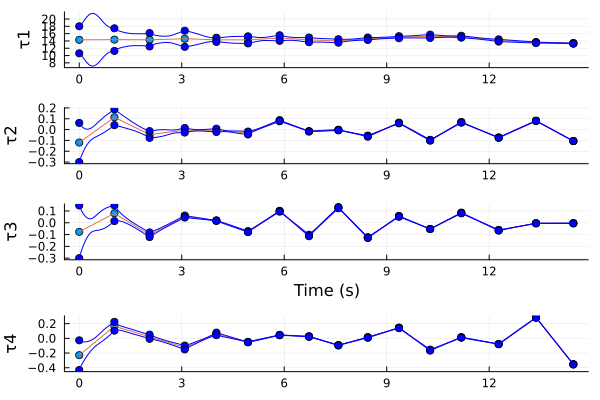

In [189]:
p = []
for idx in 1:4
    push!(p,plot(tnom,unom[idx,:],seriestype = :scatter,label=""))
    plot!(tprop,uprop[idx,:],label="")
    plot!(tnom,unom[idx,:] + input_proj_funl_nom[idx],color=:blue,seriestype = :scatter,label="")
    plot!(tprop,uprop[idx,:] + input_proj_funl_prop[idx],color=:blue,label="")
    plot!(tnom,unom[idx,:] - input_proj_funl_nom[idx],color=:blue,seriestype = :scatter,label="")
    plot!(tprop,uprop[idx,:] - input_proj_funl_prop[idx],color=:blue,label="")
    if idx == 3
        xlabel!("Time (s)")
    end
    ylabel!("τ" * string(idx))
end
plot(p[1],p[2],p[3],p[4],layout=(4,1))

## Check eigenvalue of Q

In [190]:
min_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
end
min_lam_q = zeros(size(Qnode,3))
for i in 1:size(Qnode,3)
    eigvals = eigen(Qnode[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

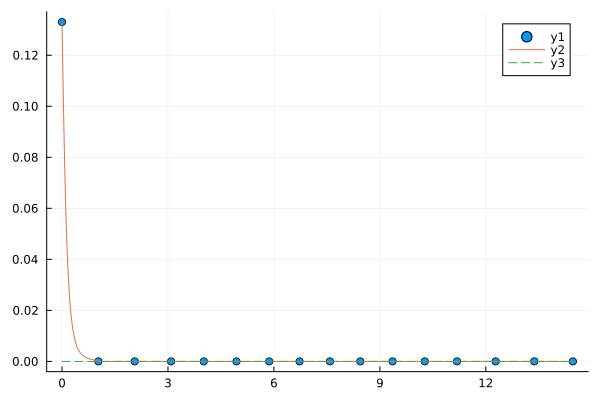

In [191]:
scatter(tnom,min_lam_q,seriestype="o")
plot!(tprop,min_lam_qprop)
plot!(tnom,tnom .* 0,linestyle=:dash)

In [192]:
findfirst(x -> x < 0, min_lam_q)

# Generate samples

In [193]:
using Random
using LinearAlgebra

In [194]:
xs_list = []
for i in 1:10
    z = randn(ix)
    z = z / norm(z)
    push!(xs_list,xnom[:,1] + sqrt(Qnode[:,:,1]) * z)
end

In [195]:
xsam_fwd,tsam,xsam,usam = [],[],[],[]
xnom_sam = []
for xs in xs_list
    xf_,ts_,xsam_,usam_,_ = propagate_from_funnel_entry(xs,DLMI,dynamics,xnom,unom,dtnom,Knode)
    push!(xsam_fwd,xf_)
    push!(tsam,ts_)
    push!(xsam,xsam_)
    push!(usam,usam_)
    # push!(xnom_sam,xnom_)
end

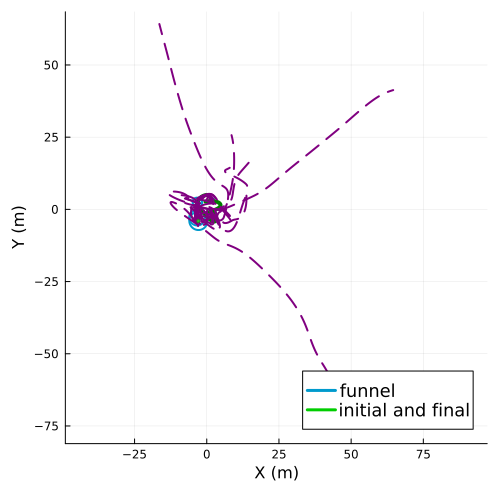

In [196]:
p2 = Plots.plot(; size=(500,500))
for idx in 1:size(Qnode,3)
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[1:2,1:2,idx],xnom[1:2,idx],"deepskyblue3",label=label,alpha=0.01)
end
plot!(xprop[1,:],xprop[2,:],aspect_ratio=:equal,c=:green,linestyle=:dash,linewidth=4.0,label=nothing)
for xs_ in xsam
    plot!(xs_[1,:],xs_[2,:],aspect_ratio=:equal,c=:purple,linestyle=:dash,linewidth=2.0,label=nothing)
end
# scatter!(xnom[1,:],xnom[2,:],aspect_ratio=:equal,c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
xlabel!("X (m)")
ylabel!("Y (m)")
display(p2)

In [ ]:
p = []
for idx in 1:3
    push!(p,plot(tnom,xnom[idx,:],seriestype = :scatter,label=""))
    plot!(tprop,xprop[idx,:],label="")
    for (ts_,xs_) in zip(tsam,xsam)
        plot!(ts_,xs_[idx,:],color=:purple,label="")
    end
    plot!(tnom,xnom[idx,:] + sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] + sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    plot!(tnom,xnom[idx,:] - sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] - sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    if idx == 3
        xlabel!("Time (s)")
    end
    ylabel!("x" * string(idx))
end
plot(p[1],p[2],p[3],layout=(3,1))

In [ ]:
p = []
for idx_ in 1:3
    idx = idx_ + 3
    push!(p,plot(tnom,xnom[idx,:],seriestype = :scatter,label=""))
    plot!(tprop,xprop[idx,:],label="")
    for (ts_,xs_) in zip(tsam,xsam)
        plot!(ts_,xs_[idx,:],color=:purple,label="")
    end
    plot!(tnom,xnom[idx,:] + sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] + sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    plot!(tnom,xnom[idx,:] - sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] - sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    if idx == 3
        xlabel!("Time (s)")
    end
    ylabel!("v" * string(idx_))
end
plot(p[1],p[2],p[3],layout=(3,1))

In [ ]:
p = []
for idx in 1:4
    push!(p,plot(tnom,unom[idx,:],seriestype = :scatter,label=""))
    plot!(tprop,uprop[idx,:],label="")
    for (ts_,us_) in zip(tsam,usam)
        plot!(ts_,us_[idx,:],color=:purple,label="")
    end
    plot!(tnom,unom[idx,:] + input_proj_funl_nom[idx],color=:blue,seriestype = :scatter,label="")
    plot!(tprop,uprop[idx,:] + input_proj_funl_prop[idx],color=:blue,label="")
    plot!(tnom,unom[idx,:] - input_proj_funl_nom[idx],color=:blue,seriestype = :scatter,label="")
    plot!(tprop,uprop[idx,:] - input_proj_funl_prop[idx],color=:blue,label="")
    if idx == 3
        xlabel!("Time (s)")
    end
    ylabel!("τ" * string(idx))
end
plot(p[1],p[2],p[3],p[4],layout=(4,1))

In [ ]:
# using JLD2, FileIO
# my_dict = Dict("Q" => Qnode, "K" => Knode, "Z" => Znode, "S" => Snode, "alpha" => alpha)
# @save "./data/quadstar_N15_funl" my_dict

# Gif

In [ ]:
using Interpolations
fps = 30
dtplot = 0.01
n = ceil(Int, (tnom[end] - tnom[1]) / dtplot) + 1
tplot = collect(range(tnom[1], step=dtplot, length=n))
println(tplot)

In [ ]:
using Random
using LinearAlgebra

In [ ]:
p2 = Plots.plot(; size=(500,500))
plot!(xprop[1,:],xprop[2,:],aspect_ratio=:equal,c=:green,linestyle=:dash,linewidth=1.5,label=nothing)
scatter!(xnom[1,:],xnom[2,:],aspect_ratio=:equal,c=:green,linestyle=:dash,linewidth=1.5,label=nothing)
xlabel!("X (m)")
ylabel!("Y (m)")
# savefig("./data_image/nominal_trajectory_qudrotor_star.pdf")

In [ ]:
p2 = Plots.plot(; size=(500,500))
for idx in 1:size(Qprop,3)
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qprop[1:2,1:2,idx]/50,xprop[1:2,idx],"deepskyblue3",label=label,alpha=0.01)
end
plot!(xprop[1,:],xprop[2,:],aspect_ratio=:equal,c=:green,linestyle=:dash,linewidth=4.0,label=nothing)
# scatter!(xnom[1,:],xnom[2,:],aspect_ratio=:equal,c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
# plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
# plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
# for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
#     label = nothing
#     if idx == 1
#         label = "obstacle"
#     end
#     plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
# end
xlabel!("X (m)")
ylabel!("Y (m)")
display(p2)
# savefig("./data_image/funnel_quadrotor_star.pdf")

In [ ]:
p2 = Plots.plot(; size=(500,500))
for idx in 1:size(Qprop,3)
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qprop[1:2,1:2,idx]/50,xprop[1:2,idx],"deepskyblue3",label=label,alpha=0.01)
end
plot!(xprop[1,:],xprop[2,:],aspect_ratio=:equal,c=:green,linestyle=:dash,linewidth=4.0,label=nothing)
for x_ in xsam
    plot!(x_[1,:],x_[2,:],color="purple",label=nothing)
end
xlabel!("X (m)")
ylabel!("Y (m)")
display(p2)
savefig("./data_image/funnel_quadrotor_star.pdf")